In [3]:
import copy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.linear_model import LinearRegression

### Dataset

In [4]:
dataset_cols = ["bike_count", "hour", "temp", "humidity", "wind", "visibility", "dew_pt_temp", "radiation", "rain", "snow", "functional"]
df = pd.read_csv("./datas/bike_data.csv").drop(["Date", "Holiday", "Seasons"], axis=1)
df.columns = dataset_cols
df["functional"] = (df["functional"] == "Yes").astype(int)

# Only concider data at 12 pm
df = df[df["hour"] == 12]
df = df.drop(["hour", "wind", "visibility", "functional"], axis=1)
df.head(5)

,bike_count,temp,humidity,dew_pt_temp,radiation,rain,snow
12,449,1.7,23,-17.2,1.11,0.0,0.0
36,479,4.3,41,-7.8,1.09,0.0,0.0
60,333,5.8,85,3.4,0.43,0.0,0.0
84,393,-0.3,38,-12.9,1.11,0.0,0.0
108,321,-2.3,25,-19.7,0.00,0.0,0.0


### Splitting Dataset

In [5]:
def get_xy(dataframe, y_label, x_labels=None):
  dataframe = copy.deepcopy(dataframe)
  if x_labels is None:
    x = dataframe[[c for c in dataframe.columns if c!=y_label]].values
  else:
    if len(x_labels) == 1:
      x = dataframe[x_labels[0]].values.reshape(-1, 1)
    else:
      x = dataframe[x_labels].values

  y = dataframe[y_label].values.reshape(-1, 1)
  data = np.hstack((x, y))

  return data, x, y

In [6]:
train, valid, test = np.split(df.sample(frac=1), [int(0.6*len(df)), int(0.8*len(df))])

# Predict result from Temperature only
train_data_temp, x_train_temp, y_train_temp = get_xy(train, "bike_count", x_labels=["temp"])
valid_data_temp, x_valid_temp, y_valid_temp = get_xy(valid, "bike_count", x_labels=["temp"])
test_data_temp, x_test_temp, y_test_temp = get_xy(test, "bike_count", x_labels=["temp"])

# Predict resut from all categories
train_data_all, x_train_all, y_train_all = get_xy(train, "bike_count", x_labels=df.columns[1:])
valid_data_all, x_valid_all, y_valid_all = get_xy(valid, "bike_count", x_labels=df.columns[1:])
test_data_all, x_test_all, y_test_all = get_xy(test, "bike_count", x_labels=df.columns[1:])

d:\Softskills\Python\Machine Learning\venv\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


### Linear Regression (Temperature)

In [7]:
temp_reg = LinearRegression()
temp_reg.fit(x_train_temp, y_train_temp)
temp_reg.score(x_valid_temp, y_valid_temp)

0.42916449320422156

In [8]:
y_predict = temp_reg.predict(x_test_temp)

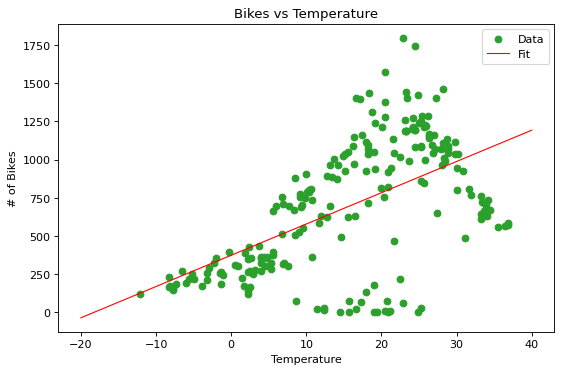

In [9]:
plt.figure(figsize = (8,5), dpi = 80)
plt.scatter(x_train_temp, y_train_temp, label="Data", color="#2CA02C")
x = tf.linspace(-20, 40, 101)
plt.plot(x, temp_reg.predict(np.array(x).reshape(-1, 1)), label="Fit", color="red", linewidth=1)
plt.legend()
plt.title("Bikes vs Temperature")
plt.ylabel("# of Bikes")
plt.xlabel("Temperature")
plt.show()

### Multiple Linear Regression (All)

In [10]:
all_reg = LinearRegression()
all_reg.fit(x_train_all, y_train_all)
all_reg.score(x_valid_all, y_valid_all)

0.6132479616506135

In [11]:
y_pred_lr = all_reg.predict(x_test_all)

### Regression using Neural Network (Temperature)

In [12]:
def plot_loss(history):
  plt.figure(figsize = (8,5), dpi = 80)
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error (MSE)')
  plt.legend()
  plt.grid(True)
  plt.show()

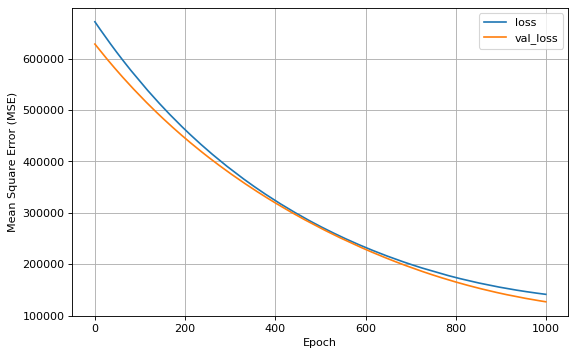

In [13]:
temp_normalizer = tf.keras.layers.Normalization(input_shape=(1,), axis=None)
temp_normalizer.adapt(x_train_temp.reshape(-1))

temp_reg_nn_model = tf.keras.Sequential([
    temp_normalizer,
    tf.keras.layers.Dense(1)
])

temp_reg_nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1), loss='mean_squared_error')

history = temp_reg_nn_model.fit(x_train_temp.reshape(-1), y_train_temp, verbose=0, epochs=1000, validation_data=(x_valid_temp, y_valid_temp))

plot_loss(history)

4/4 [==============================] - 0s 0s/step


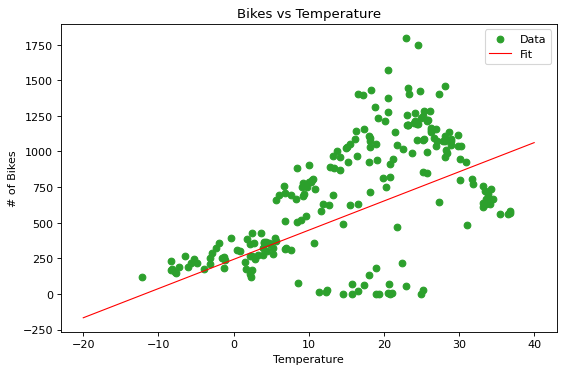

In [14]:
plt.figure(figsize = (8,5), dpi = 80)
plt.scatter(x_train_temp, y_train_temp, label="Data", color="#2CA02C")
x = tf.linspace(-20, 40, 101)
plt.plot(x, temp_reg_nn_model.predict(np.array(x).reshape(-1, 1)), label="Fit", color="red", linewidth=1)
plt.legend()
plt.title("Bikes vs Temperature")
plt.ylabel("# of Bikes")
plt.xlabel("Temperature")
plt.show()

### Neural Network (Temperature)

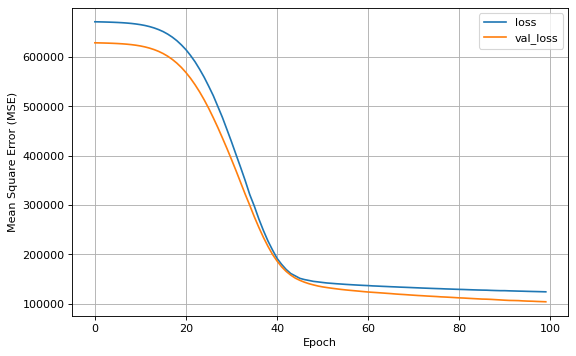

In [15]:
temp_normalizer = tf.keras.layers.Normalization(input_shape=(1,), axis=None)
temp_normalizer.adapt(x_train_temp.reshape(-1))

temp_nn_model = tf.keras.Sequential([
    temp_normalizer,
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])
temp_nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')

history = temp_nn_model.fit(x_train_temp, y_train_temp, validation_data=(x_valid_temp, y_valid_temp), verbose=0, epochs=100)

plot_loss(history)

4/4 [==============================] - 0s 4ms/step


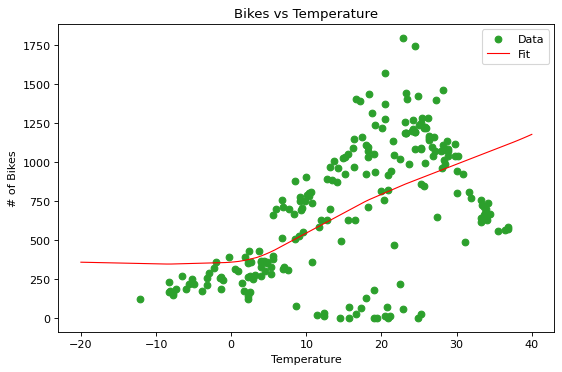

In [16]:
plt.figure(figsize = (8,5), dpi = 80)
plt.scatter(x_train_temp, y_train_temp, label="Data", color="#2CA02C")
x = tf.linspace(-20, 40, 101)
plt.plot(x, temp_nn_model.predict(np.array(x).reshape(-1, 1)), label="Fit", color="red", linewidth=1)
plt.legend()
plt.title("Bikes vs Temperature")
plt.ylabel("# of Bikes")
plt.xlabel("Temperature")
plt.show()

### Neural Network (All)

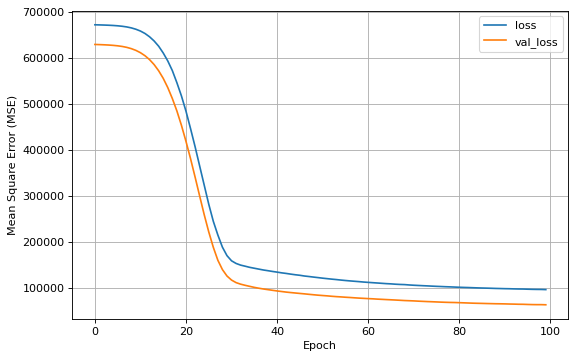

In [17]:
all_normalizer = tf.keras.layers.Normalization(input_shape=(6,), axis=-1)
all_normalizer.adapt(x_train_all)

all_nn_model = tf.keras.Sequential([
    all_normalizer,
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])
all_nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')

history = all_nn_model.fit(x_train_all, y_train_all, validation_data=(x_valid_all, y_valid_all), verbose=0, epochs=100)

plot_loss(history)

### Mean Square Error for LR vs NN

In [18]:
def MSE(y_pred, y_real):
  return (np.square(y_pred - y_real)).mean()

3/3 [==============================] - 0s 3ms/step


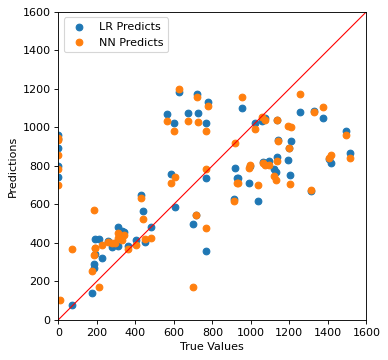

In [19]:
y_pred_lr = all_reg.predict(x_test_all)
y_pred_nn = all_nn_model.predict(x_test_all)
MSE(y_pred_lr, y_test_all)
MSE(y_pred_nn, y_test_all)

plt.figure(figsize = (8,5), dpi = 80)
ax = plt.axes(aspect="equal")
plt.scatter(y_test_all, y_pred_lr, label="LR Predicts")
plt.scatter(y_test_all, y_pred_nn, label="NN Predicts")
plt.xlabel("True Values")
plt.ylabel("Predictions")
lims = [0, 1600]
plt.xlim(lims)
plt.ylim(lims)
plt.legend()
plt.plot(lims, lims, c="red", linewidth=1)